This notebook plots timeseries of global-mean T200, T850 and total water path in year-long prognostic runs. It depends on diagnostics computed by the `prognostic-reports` workflow.

It generates Figure S5.

In [1]:
import xarray as xr
import fsspec
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
xr.set_options(keep_attrs=True)

In [2]:
urls = {
    'baseline': 'gs://vcm-ml-public/argo/2020-11-10-n2o-climate-runs/baseline/diags.nc',
    'rf-control': 'gs://vcm-ml-public/argo/2021-03-15-n2o-climate-runs/rf-control/diags.nc',
    'rf-dQ1-dQ2-only': 'gs://vcm-ml-public/argo/2021-03-15-n2o-climate-runs/rf-dQ1-dQ2-only/diags.nc',
}
variables = ['pwat', 'tmp850', 'tmp200']

In [3]:
variables_to_keep = [
    f"{v}_{reduction}_dycore_global"
    for reduction in ["spatial_mean", "mean_bias"]
    for v in variables
]
diags = []
for run, url in urls.items():
    with fsspec.open(url) as f:
        ds = xr.open_dataset(f).load()
        diags.append(ds[variables_to_keep].assign_coords(experiment=run))
diags = xr.concat(diags, dim='experiment')

In [4]:
baseline = diags.sel(experiment='baseline')
verif = xr.Dataset()
for varname in variables:
    verif_array = baseline[f"{varname}_spatial_mean_dycore_global"] - baseline[f"{varname}_mean_bias_dycore_global"]
    verif[f"{varname}_spatial_mean_dycore_global"] = verif_array
verif = verif.assign_coords(experiment='verification')

In [5]:
diags = xr.concat([verif, diags], dim='experiment')

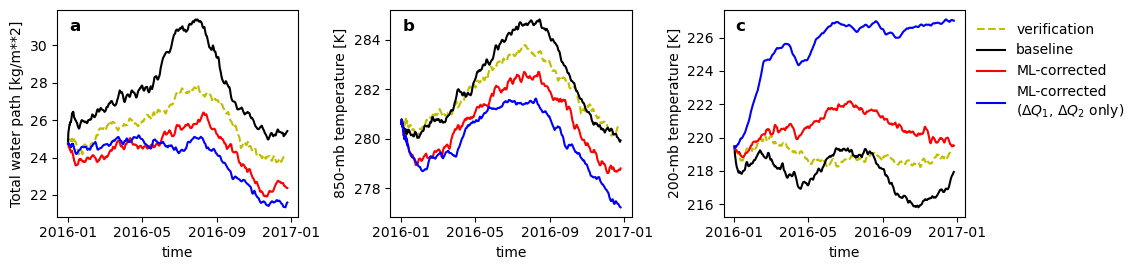

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(11.5, 2.8))
plot_experiments = ['verification', 'baseline', 'rf-control', 'rf-dQ1-dQ2-only']
labels = ['verification', 'baseline', 'ML-corrected', 'ML-corrected\n($\Delta Q_1$, $\Delta Q_2$ only)']
colors = ['y', 'k', 'r', 'b']
linestyles = ['--', '-', '-', '-']
titles = ['a', 'b', 'c']
for j, varname in enumerate(variables):
    longname = f"{varname}_spatial_mean_dycore_global"
    for i, exp in enumerate(plot_experiments):
        diags[longname].sel(experiment=exp).plot.line(ax=axes[j], label=labels[i], color=colors[i], linestyle=linestyles[i])
    axes[j].text(0.05, 0.9, titles[j], transform=axes[j].transAxes, fontsize=12, fontweight='bold')
    axes[j].set_title('')
    if j == 2:
        axes[j].legend(frameon=False, bbox_to_anchor=(1,1))
plt.tight_layout()